<a href="https://colab.research.google.com/github/siddsh/Movie-Review-Classification/blob/master/BERT_for_Movie_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Lots of Imports
import os
import math
import datetime
import tensorflow_datasets as tfds
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch



%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

#Dataset

In [ ]:
#Download the IMDb Reviews datasets from TensorFlow Datasets
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Overwrite dataset info from restored data version.
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


In [ ]:
train_data, test_data = imdb['train'], imdb['test']

In [ ]:
#Get all Training sentences in an array
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
training_sentences[0]

'b"This was an absolutely terrible movie. Don\'t be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie\'s ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor\'s like Christopher Walken\'s good name. I could barely sit through it."'

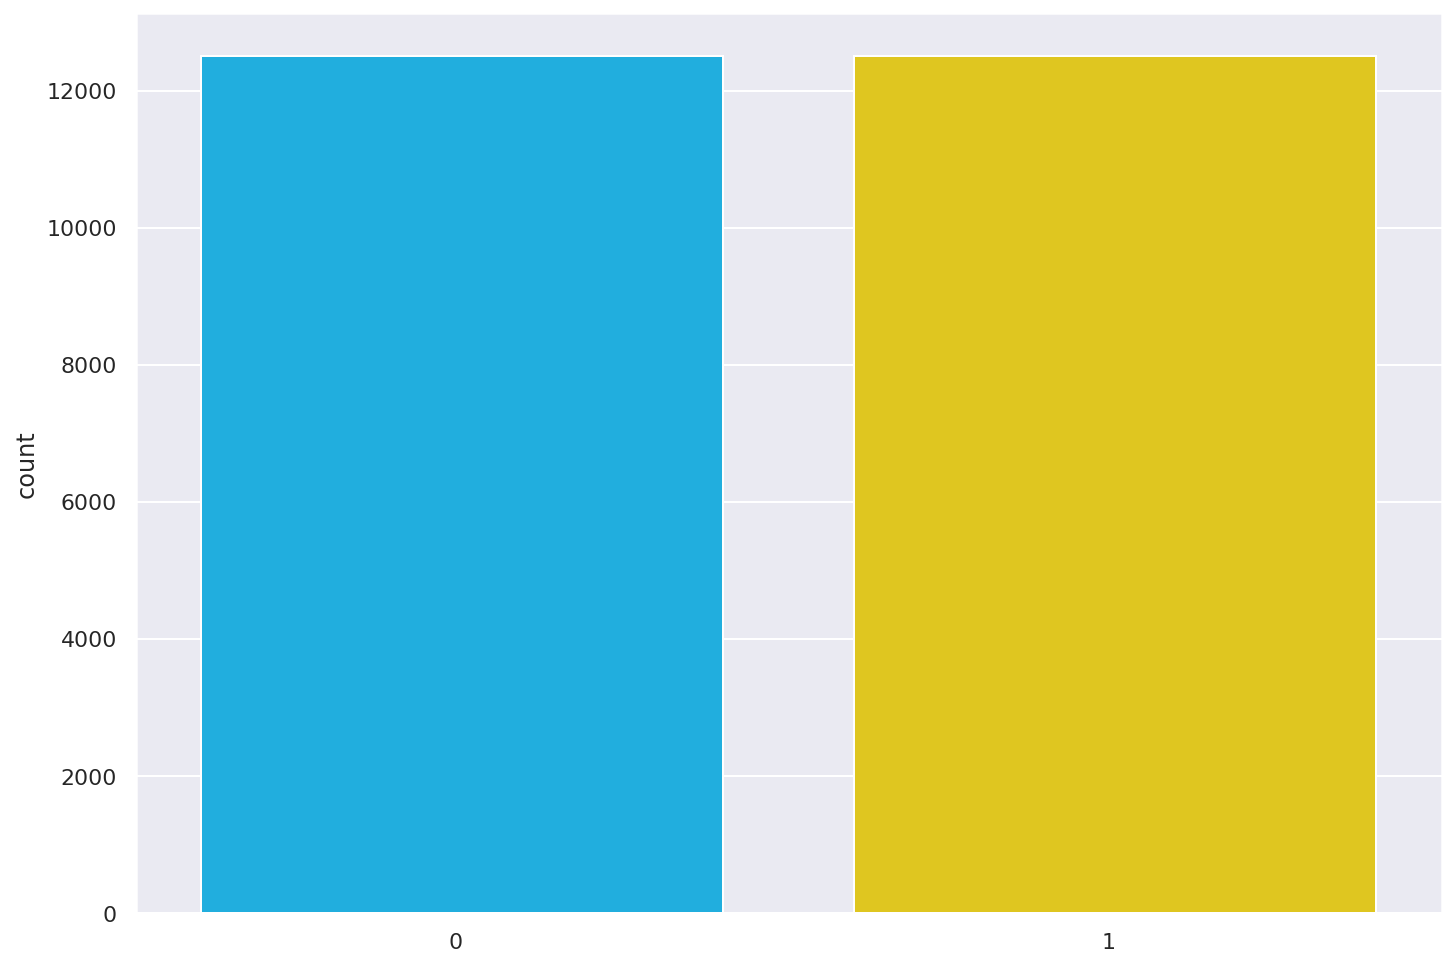

In [ ]:
#Draw the countplot of the training data
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
#sns.set(style='dark', palette='muted', font_scale=1.2 )
sns.set(rc={'figure.figsize':(11.7,8.27) } )
#sns.set_style({'figure.facecolor': 'grey', 'axes.facecolor': 'grey'})
chart = sns.countplot(training_labels_final, palette=HAPPY_COLORS_PALETTE)
chart.set_xticklabels(chart.get_xticklabels(), rotation=0, horizontalalignment='right');

#BERT

In [ ]:
#Dont worry if you don't have a GPU run the next cell and torch will use CPU but it will be very slow for training
#Highly Recommend to use GPU for training

#GPU NAME
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print("GPU at: {}".format(device_name))
else:
    raise SystemError("GPU not found")

GPU at: /device:GPU:0


In [ ]:
#if GPU available
if torch.cuda.is_available():
    #USE GPU BY PyTorch
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' %torch.cuda.device_count())
    print('Will use GPU: ', torch.cuda.get_device_name(0))
else:
    print('NO GPU available, using CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Will use GPU:  Tesla P100-PCIE-16GB


In [81]:
#Libs for checking Memory Usage
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 9.7 GB  | Proc size: 5.6 GB
GPU RAM Free: 11587MB | Used: 4693MB | Util  29% | Total 16280MB


In [ ]:
#Huggingface Transformers library Interface to BERT
!pip install transformers

#Feature Extraction (Tokenizer) 

In [ ]:
from transformers import BertTokenizer

#Load BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
print('done')

Loading BERT tokenizer...
done


##Dont Worry about the warnings 
It Warns when the data is greater than 512 as the model can only take 512 (techinically 510) tokens


In [ ]:
#tokenize all sentenxes and map the tokens to their word ID
input_ids = []

#record Length of each sequence (after truncation to 512)
lengths = []

print('Tokenizing comments...')

for sen in training_sentences:

    if((len(input_ids) % 20000) == 0):
        print('Read {:,} comments.'.format(len(input_ids)))

    #''encode'' will
    # (1) Tokenize sentences.
    # (2) Prepend the '[CLS]' 
    # (3) Append the '[SEP]'
    # (4) Map the tokens to their ID

    encoded_send = tokenizer.encode(sen, add_special_tokens= True)

    #Add the encoded sentense to the list.
    input_ids.append(encoded_send)

    #Record the truncated length
    lengths.append(len(encoded_send))

print('DONE')
print('{:>10,} comments'.format(len(input_ids)))


Token indices sequence length is longer than the specified maximum sequence length for this model (960 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (830 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


Tokenizing comments...
Read 0 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (672 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1034 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1017 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

Read 20,000 comments.


Token indices sequence length is longer than the specified maximum sequence length for this model (726 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (692 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1301 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for t

DONE
    25,000 comments


In [ ]:
##Stastics of the data
print('   Min Length: {:,}'.format(min(lengths)))
print('   Max Length: {:,}'.format(max(lengths)))
print('Median Length: {:,}'.format(np.median(lengths)))

   Min Length: 16
   Max Length: 512
Median Length: 239.0


Text(0, 0.5, '# of tenders')

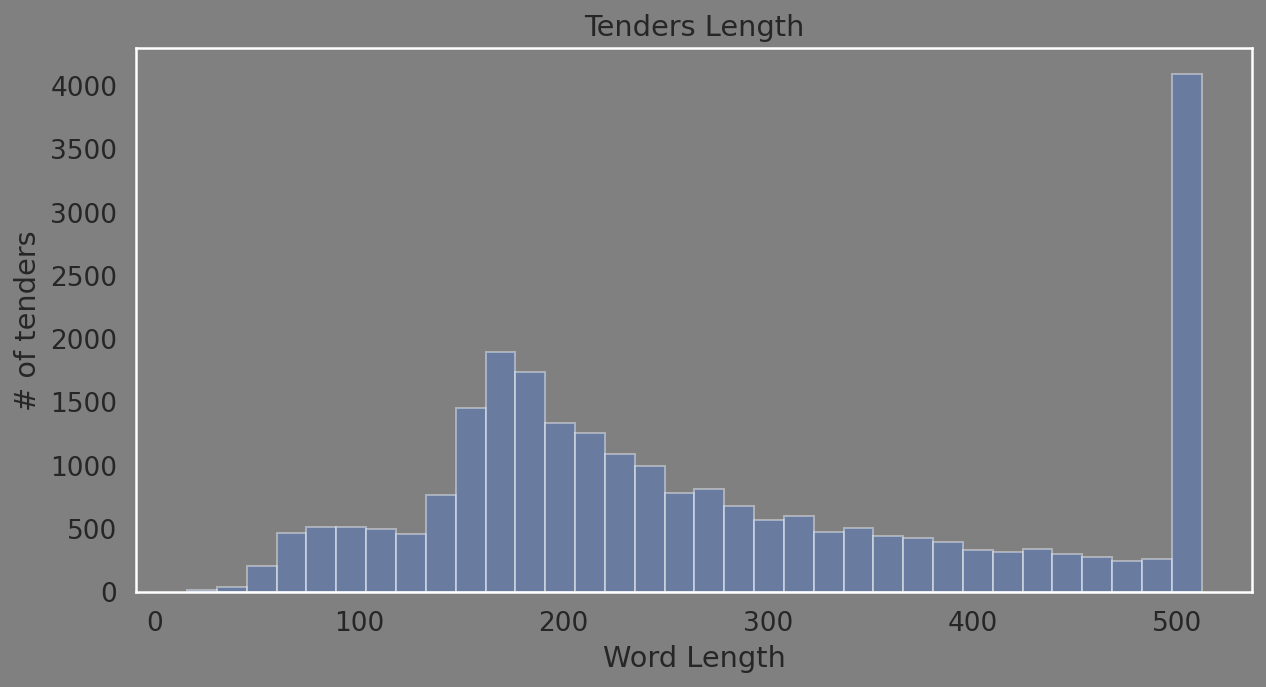

In [ ]:
#plot the graph
#increase plot size and font size
sns.set(font_scale=1.5)
sns.set(style='dark', palette='muted', font_scale=1.2 )
plt.rcParams['figure.figsize'] = (10,5)
sns.set_style({'figure.facecolor': 'grey', 'axes.facecolor': 'grey'})
#truncate ant comment > 512 length
lengths = [min(l,512) for l in lengths]

#plot the distribution
sns.distplot(lengths, kde=False, rug=False)
#plt.style.use('dark_background')
plt.title('Tenders Length')
plt.xlabel('Word Length')
plt.ylabel("# of tenders")

In [ ]:
#count the number of sentences above 512
num_truncated = lengths.count(512)

#compare this to the total training sentences
num_sentences = len(lengths)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens.'.format(num_truncated, num_sentences, prcnt))

3,897 of 25,000 sentences (15.6%) in the training set are longer than 512 tokens.


##Change the Reduce MAX_LEN or reduce batch size if CUDA Out of memory

In [ ]:
#PAD SEQUENCES FROM KERAS
from keras.preprocessing.sequence import pad_sequences

#set required sequence length
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' %MAX_LEN)

print('\nPadding Token: "{:}, ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

#Pad token with value 0
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', value=0, truncating='post', padding='post')

print('Done')


Padding/truncating all sentences to 512 values...

Padding Token: "[PAD], ID: 0
Done


In [ ]:
#create attention masks
attention_masks = []

for sent in input_ids:

    #Create attention mask
    # -IF a token ID is 0 then its padding 
    # else real token, set mask to 1
    att_mask = [(int)(token_id>0) for token_id in sent]

    #store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
#90:10 split 
#Validation
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, training_labels_final, random_state=2018, test_size = 0.1)

#masks
train_masks, validation_masks, _, _ = train_test_split(attention_masks, training_labels_final, random_state=2018, test_size = 0.1)

In [ ]:
#Convert to pytorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.from_numpy(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#batch Sampler 32 or 16
batch_size = 16

#create a dataloader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

#create dataloader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
len(train_dataloader)

1407

#Bert Model

In [ ]:
#Load the pretrained model about 440MB
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',#12 layer model uncased vocab
    num_labels = 2, #the number of output labels
    output_attentions = False,# Weather the model returns the attention weights
    output_hidden_states = False, #weather model returns all the hidden states
)

#tell pytorch to run model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
printm()

Gen RAM Free: 10.0 GB  | Proc size: 5.5 GB
GPU RAM Free: 14923MB | Used: 1357MB | Util   8% | Total 16280MB


##Optimizer and Learning Rate Scheduler

In [ ]:
#AdamW is for huggingface library
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

#no of ephocs
#Trained on 3 
ephocs = 1

#Total number of training steps is number of batches * number of ephocs
total_steps = len(train_dataloader) * ephocs

#create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
#Training loop
import numpy as np
#calculate accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
def format_time(elapsed):
    '''Takes time in sec and returns string hh:mm:ss'''
    #round to nearest second
    elapsed_rounded = int(round((elapsed)))

    #format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
len(train_dataloader)

1407

##Training Loop

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#Store the average loss to plot
loss_values = []

for epoch_i in range(0,ephocs):
    print('')
    print('============= Ephocs {:} / {:} ============='.format(epoch_i +1, ephocs))
    print('Training...')

    #measure how long training ephocs takes
    t0 = time.time()

    #reset loss for this ephocs
    total_loss = 0

    model.train()
    for step, batch in enumerate(train_dataloader):
        #progress update every 100 batches
        if step % 100 == 0 and not step == 0:
            #elapsed time in min
            elapsed = format_time(time.time() - t0)
            #Report progress
            print('Batch {:>5,}. Elapsed: {:}.'.format(step, elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device) 
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    #calculate the avg loss
    avg_train_loss = total_loss / len(train_dataloader)

    #store the loss value for plotting
    loss_values.append(avg_train_loss)

    print('')
    print('Average training loss: {0:.2f}'.format(avg_train_loss))
    print('')

    #validation
    print('')
    print("Running Validation...")

    t0=time.time()

    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    #Evaluate for one epoch
    for batch in validation_dataloader:

        #add batch to GPu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]

        #move it to GPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        #calculate the accuracy for the batch of test sentences
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        #accumulate total accuracy
        eval_accuracy += tmp_eval_accuracy 

        nb_eval_steps +=1
        

    #report
    print('Validation Accuracy: {0:.2f}'.format(eval_accuracy/nb_eval_steps))
    print('Validation took: {:}'.format(format_time(time.time() - t0)))

print('')
print("training complete")


============= Ephocs 1 / 3 =============
Training...
Batch   100. Elapsed: 0:01:25.
Batch   200. Elapsed: 0:02:50.
Batch   300. Elapsed: 0:04:16.
Batch   400. Elapsed: 0:05:41.
Batch   500. Elapsed: 0:07:06.
Batch   600. Elapsed: 0:08:31.
Batch   700. Elapsed: 0:09:56.
Batch   800. Elapsed: 0:11:21.
Batch   900. Elapsed: 0:12:46.
Batch 1,000. Elapsed: 0:14:11.
Batch 1,100. Elapsed: 0:15:36.
Batch 1,200. Elapsed: 0:17:01.
Batch 1,300. Elapsed: 0:18:26.
Batch 1,400. Elapsed: 0:19:51.

Average training loss: 0.26


Running Validation...
Validation Accuracy: 0.94
Validation took: 0:00:45

============= Ephocs 2 / 3 =============
Training...
Batch   100. Elapsed: 0:01:25.
Batch   200. Elapsed: 0:02:50.
Batch   300. Elapsed: 0:04:15.
Batch   400. Elapsed: 0:05:40.
Batch   500. Elapsed: 0:07:05.
Batch   600. Elapsed: 0:08:30.
Batch   700. Elapsed: 0:09:55.
Batch   800. Elapsed: 0:11:20.
Batch   900. Elapsed: 0:12:45.
Batch 1,000. Elapsed: 0:14:11.
Batch 1,100. Elapsed: 0:15:36.
Batch 1,200. 

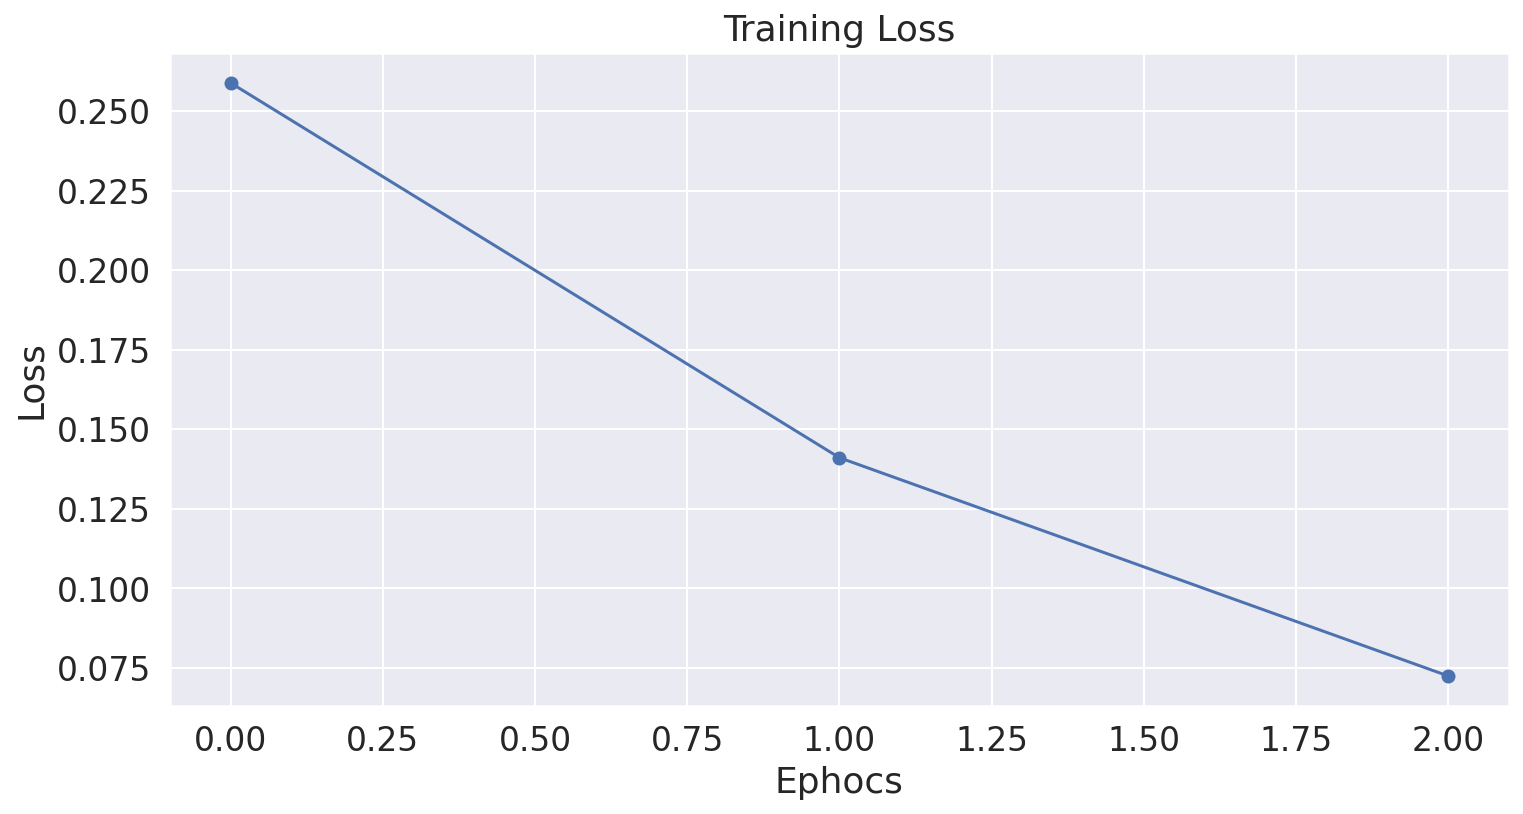

In [ ]:
#Plot training loss
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#use plot styling from seabor
sns.set(style='darkgrid')

#increase plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

#plot the distribution
plt.plot(loss_values, 'b-o')

plt.title('Training Loss')
plt.xlabel('Ephocs')
plt.ylabel("Loss")

plt.show()

#Test


In [ ]:
train_inputs, test_inputs, train_labels_init, test_labels = train_test_split(testing_sentences, testing_labels, random_state=2018, test_size = 0.25)

In [ ]:
#tokenize all of the sentences and map them the tokens to the words to their ID
test_input_ids = []
MAX_LEN = 512
for sen in test_inputs:
    #Report progress
    if((len(test_input_ids) % 500) == 0):
        print("READ {} comments".format(len(test_input_ids)))

    encoded_sent = tokenizer.encode(sen, add_special_tokens = True, max_length = MAX_LEN)

    #Add encoded sen to list
    test_input_ids.append(encoded_sent)
print("Done")
print("")
print("{:>10,} test comments".format(len(test_input_ids)))

#LABELS
test_labels = test_labels

#Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

#Create attention mask
test_attention_masks = []

#Mask for each token followed by 0s for padding
for seq in test_input_ids:
    seq_mask = [float(i>0) for i in seq]
    test_attention_masks.append(seq_mask)

#convert to tensor
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

batch_size = 32

#dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 0 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 500 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 1000 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 1500 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 2000 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 2500 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 3000 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 3500 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 4000 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 4500 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 5000 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 5500 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

READ 6000 comments


Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

Done

     6,250 test comments


#Evaluate

In [67]:
#Tokenize all the test_sentences and predict it
print("Predicting the labels for {:,}, test sentences...".format(len(test_inputs)))

#Put model in evaluation
model.eval()

#Tracking variables
predictions, true_labels = [], []

#measure elapsed time
t0 = time.time()

#predict
for (step, batch) in enumerate(test_dataloader):

    #Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    #Progress every 50 batches
    if step % 50 == 0 and not step == 0:
        #Find elapsed time
        elapsed = format_time(time.time() - t0)

        #Progress Report
        print('Batch{:>5,} of {:%>,}. Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))
    
    #Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    #Telling model to not compute or store gradients, saving memory and speeding predictions
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, token_type_ids=None)
    
    logits = outputs[0]

    #Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print("DONE")

Predicting the labels for 6,250, test sentences...
Batch   50 of 196. Elapsed: 0:00:28.
Batch  100 of 196. Elapsed: 0:00:55.
Batch  150 of 196. Elapsed: 0:01:23.
DONE


In [68]:
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [69]:
#Both should have the same size
predictions.shape

(6250, 2)

In [70]:
true_labels.shape

(6250,)

In [71]:
#Create a PyTorch tensor to keep the predictions and their corresponding labels
stacked = torch.stack(
    (
        torch.tensor(true_labels),
        torch.tensor(np.argmax(predictions, axis=1))
    )
    , dim=1
)
cmt = torch.zeros(2,2, dtype=torch.int64)
for p in stacked:
    j, k = p.tolist()
    cmt[j, k] += 1
cmt

tensor([[2926,  217],
        [ 157, 2950]])

In [72]:
#Create a dataframe to plot the heatmap
df_cm = pd.DataFrame(cmt.tolist(), index = ['Positive', 'Negative'], columns = ['Positive', 'Negative'])

In [73]:
#Metrics for model
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Accuracy: 94.016 %


			Classification Report
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      3143
           1       0.93      0.95      0.94      3107

    accuracy                           0.94      6250
   macro avg       0.94      0.94      0.94      6250
weighted avg       0.94      0.94      0.94      6250



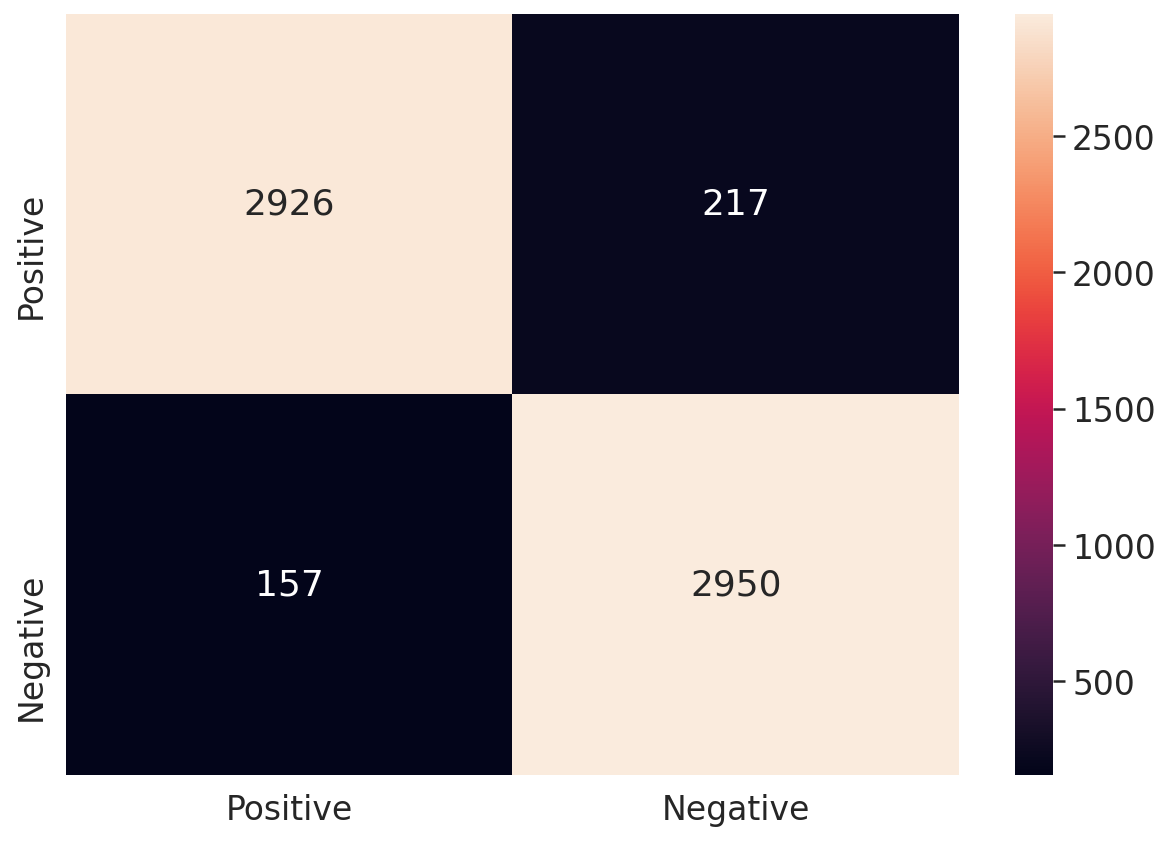

In [74]:
accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1)) 
print("Accuracy:", accuracy*100, '%')
print("\n\n\t\t\tClassification Report\n",classification_report(true_labels, np.argmax(predictions, axis=1)))
# confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')

#Save model

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [76]:
import torch
torch.save(model, '/content/drive/My Drive/model_MOVIE.pth')

#Load Model

In [ ]:
#Run this if you dont have CUDA GPU
device = torch.device('cpu')

In [77]:
import torch
newmodel = torch.load('/content/drive/My Drive/model_MOVIE.pth')
newmodel.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [78]:
review_indx = {1 : 'Positive', 0 : 'Negative'}

In [79]:
def predict_review(test_inputs):    
    #Load BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    #tokenize all of the sentences and map them the tokens to the words to their ID
    test_input_ids = []
    MAX_LEN = 330
    for sen in test_inputs:   

        encoded_sent = tokenizer.encode(sen, add_special_tokens = True, max_length = MAX_LEN)

        #Add encoded sen to list
        test_input_ids.append(encoded_sent)


    #Pad our input tokens
    test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

    #Create attention mask
    test_attention_masks = []

    #Mask for each token followed by 0s for padding
    for seq in test_input_ids:
        seq_mask = [float(i>0) for i in seq]
        test_attention_masks.append(seq_mask)

    #convert to tensor
    test_inputs = torch.tensor(test_input_ids)
    test_masks = torch.tensor(test_attention_masks)
    #test_labels = torch.tensor(test_labels)

    batch_size = 32

    #dataloader
    test_data = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    #Tracking variables
    predictions, true_labels = [], []

    #measure elapsed time
    t0 = time.time()

    #predict
    for (step, batch) in enumerate(test_dataloader):

        #Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        #Progress every 50 batches
        if step % 50 == 0 and not step == 0:
            #Find elapsed time
            elapsed = format_time(time.time() - t0)

            #Progress Report
            print('Batch{:>5,} of {:%>,}. Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))
        
        #Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch

        #Telling model to not compute or store gradients, saving memory and speeding predictions
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, token_type_ids=None)
        
        logits = outputs[0]

        #Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        #store predictions and true labels
        predictions.append(logits)

    predictions = np.concatenate(predictions, axis=0)
    plt.style.use('dark_background')
    plt.title('Review Prediction', fontsize=15)
    plt.xlabel('Confidence')
    plt.barh(list(review_indx.values())[::-1], [predictions[0][0], predictions[0][1]], color=['red', 'cyan'])
    plt.show()
    return predictions

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


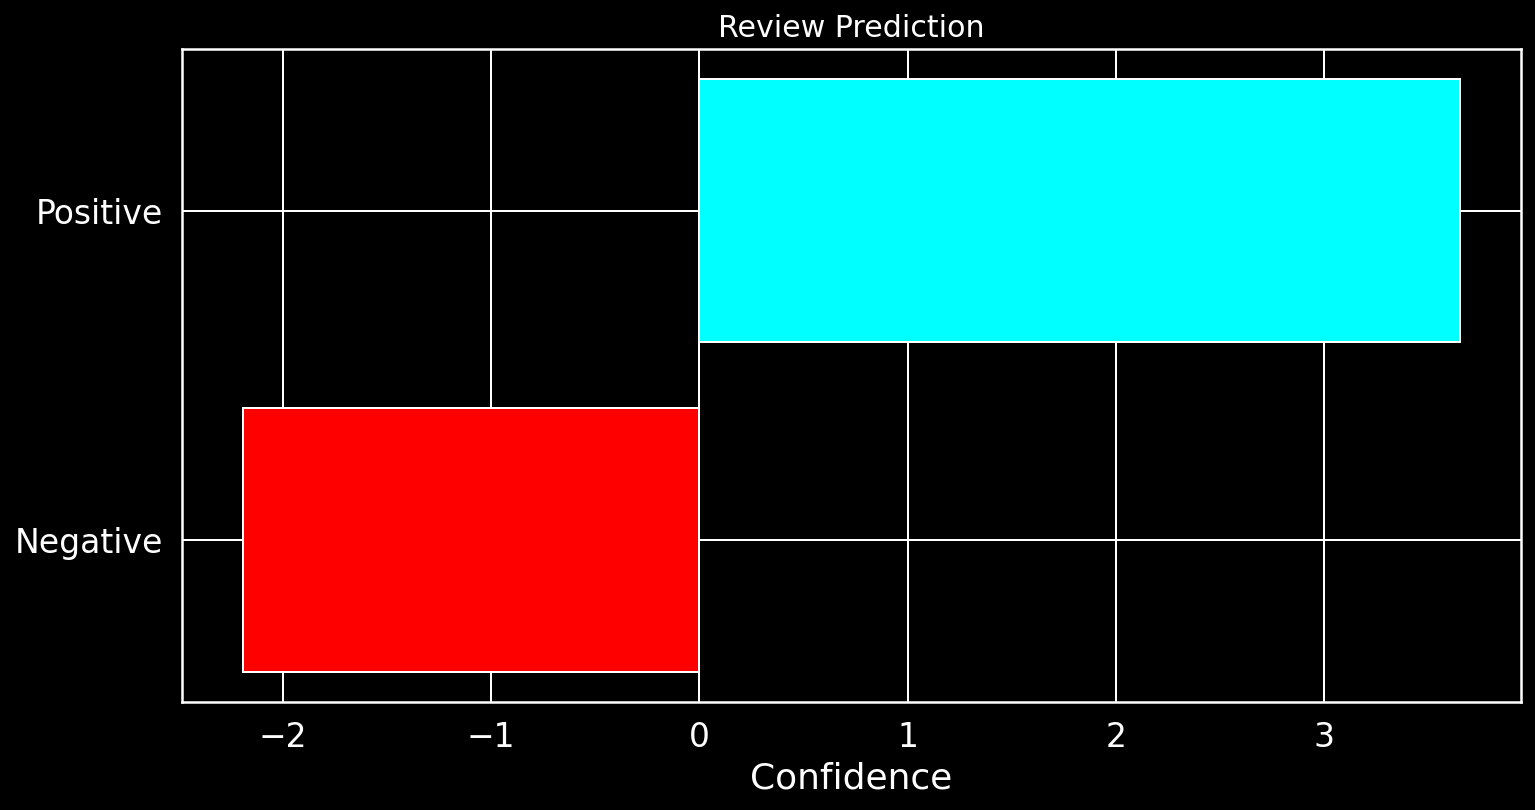

array([[-2.1918998,  3.6512668]], dtype=float32)

In [80]:
# Parasite Movie Review From 
# https://timesofindia.indiatimes.com/entertainment/english/movie-reviews/parasite/movie-review/76068392.cms
review = ["""‘Parasite’s’ opening shot of a small glass window looking up from a basement house to the view of a narrow winding road, sets the visual language of the film firmly, right at the onset. There are many more such shots which metaphorically convey the social and economic disparity that is the central theme of this film. Especially the use of stairs going up and down, cramped spaces versus lush, open green lawns, delectably and elegantly laid out fruit slices as opposed to a clumisly heaped plate of food from a local kitchen.
Kim Ki-taek (Song Kang-ho) and his family live in a pokey, underground house and are generally unemployed. When we meet them, the family is perturbed that their access to free wifi has been cut short. Obviously not able to afford their own, they have been sponging off their neighbor’s connection. In fact, even as a fumigation carried out on their street, Kim tells his family to leave the windows open so they can have a free extermination of the insects in their house, despite almost choking on the fumes. On some days, they get by with temporary jobs like fixing pizza boxes. So when his son Kim Ki-woo (Choi Woo-shik) is offered by a friend to be set up as an English tutor to the daughter of a wealthy Mr. Park (Lee Sun-kyun), he agrees. Only hitch, Kim Ki-woo doesn’t have a college degree having failed his university exams. But his sister, Kim Ki-jeong (Park So-dam) presents a quick solution to this with her expert photo-shopping skills. Armed with a forged degree document, Kim makes an easy impression on Mr.Park’s wife, Yeon-kyo (Cho Yeo-jeong) and their teenage daughter, Park Da-hye (Jung ji-so). There’s also their nine-year-old son, Park Da-song (Jung Hyeong), scampering around the house, who Yeon-kyo believes has untapped potential as an artist. With one foot firmly inside the Park household, Kim Ki-jeong craftily places his sister as Da-song’s art teacher cum therapist. Yeon-kyo's naivety and gullible nature makes this inclusion quite smooth. Soon with some careful scheming, fake identities and a well-rehearsed plan even his parents, Kim Ki-taek and Chung sook (Chang Hyae-jin) are employed in the household.
It seems like a flawless plan with the Kim family settled into their new found roles and the sunlit, lavish mansion of the Park family giving it the perfect backdrop. But just like that, director Bong Joon-ho’s screenplay springs upon us unexpected plot twists and a thrilling run up to a grisly yet astounding climax. Through a well-crafted maze of events the prevalent class conflict and social disparity come to the fore. The Kim’s are often shown huddled together as a family, gobbling away at their meals and the Park’s are often in their own expansive rooms, almost isolated from each other. In a telling scene, when Mr. Park discusses Mr.Kim’s smell that wafts through the car when he drives, ‘crossing the line’ and reaching the backseat, he describes it as an ‘old rag that has been boiled’ and ‘that smell that people who travel in the subway have’. It’s evident there is unspoken disdain is on both ends, as Chung sook quips how Yeon-kyo is ‘nice because she is rich.’
With not a moment that seems unnecessary or extra, ‘Parasite’ is exceptionally well-paced and edited (Yang Jin-mo). Director Bong Jon-ho masterfully constructs stylized, dramatic sequences set to a brilliant background score (Jung Jae-il) as the film rapidly moves from one plot point to another. It results in a gripping yet poignant watch. The ensemble cast enhance the proceedings with superlative performances, especially Song Kang-ho, Park So-dam and Choi Woo-shik.
With an insightful and searing exploration of human behavior, ‘Parasite’ is a masterfully crafted film that is a definite must watch."""]
predict_review(review)